In [1]:
import os, glob
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import scipy.stats as stats
import cv2 as cv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection as slms, preprocessing as spre
from skimage import measure as meas, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [5]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [6]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/fruits-360/Training/'

In [7]:
ban_a, app_a, ora_a = np.load('astar-ban_app_ora.npy')
ban_b, app_b, ora_b = np.load('bstar-ban_app_ora.npy')
ban_e, app_e, ora_e = np.load('ecc-ban_app_ora.npy')

ban_features = np.array([ban_a, ban_b, ban_e]).T
app_features = np.array([app_a, app_b, app_e]).T
ora_features = np.array([ora_a, ora_b, ora_e]).T

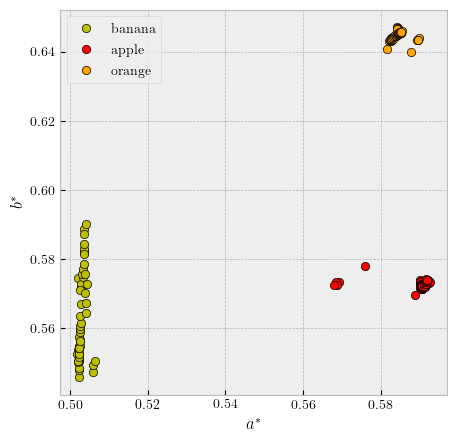

In [8]:
plt.plot(ban_features.T[0], ban_features.T[1], 'yo', mec='k', mew=0.5)
plt.plot(app_features.T[0], app_features.T[1], 'ro', mec='k', mew=0.5)
plt.plot(ora_features.T[0], ora_features.T[1], 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

In [178]:
class ExpectationMaximization:
    def __init__(self, n_classes,
                 dimensions,
                 baseline=0.1):
        self.n_classes = n_classes
        self.dimensions = dimensions
        self.baseline = baseline
    
    def _p(self, x, mu, sigma):
        return 1/(2*np.pi)**(self.dimensions/2)/la.det(sigma)**(1/2) \
             * np.exp(-1/2 * (x - mu).T.dot(la.inv(sigma)).dot(x - mu))
    
    def _P(self, l, x):
        num = self.P[l] * self._p(x, self.theta['mu'][l], self.theta['cov'][l])
        den = 0.
        for m in range(self.n_classes):
            den += self.P[m] * self._p(x, self.theta['mu'][m], self.theta['cov'][l])
        return num/den
    
    def train(self, X, cluster_means, epochs=int(1e6)):
        self.graph_loss = []
        self.epochs = epochs
        N = len(X)
        ll_old = 0.
        self.theta = dict({'mu': cluster_means,
                           'cov': np.array([np.identity(self.dimensions) \
                                            for _ in range(self.n_classes)])
                          })
        self.P = np.ones(self.n_classes) * 1/self.n_classes
        for count in tnrange(epochs, desc='Epoch'):
            exp_A = []
            exp_B = []
            ll_new = 0.
            ws = np.zeros((self.n_classes, N))
            
            for l in range(self.n_classes):
                for i, x in enumerate(X):
                    ws[l,i] = self.P[l] * \
                              stats.multivariate_normal(self.theta['mu'][l],
                                                        self.theta['cov'][l],
                                                       ).pdf(x)
            ws /= ws.sum(0)
            
            Pnew = np.zeros(self.n_classes)
            for l in range(self.n_classes):
                for i in range(N):
                    Pnew[l] += ws[l,i]
            Pnew /= N
            
            mu_new = np.zeros((self.n_classes, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    mu_new[l] += ws[l,i] * X[i]
                mu_new[l] /= ws[l].sum()
            
            cov_new = np.zeros((self.n_classes, self.dimensions, self.dimensions))
            for l in range(self.n_classes):
                for i in range(N):
                    ys = np.reshape(X[i] - mu_new[l], (2, 1))
                    cov_new[l] += ws[l,i] * ys.dot(ys.T)
                cov_new[l] /= ws[l].sum()
            
            ll_new = 0.
            for i in range(N):
                s = 0.
                for l in range(self.n_classes):
                    s += Pnew[l] * stats.multivariate_normal(self.theta['mu'][l],
                                                             self.theta['cov'][l]
                                                            ).pdf(X[i])
                ll_new += np.log(s)
            self.graph_loss.append(ll_new)
            if abs(ll_new - ll_old) < self.baseline:
                break
            ll_old = ll_new
            
            self.P = Pnew
            self.theta['mu'] = mu_new
            self.theta['cov'] = cov_new

In [268]:
astars = np.concatenate((ban_a, app_a, ora_a))
bstars = np.concatenate((ban_b, app_b, ora_b))
X = np.column_stack((astars, bstars))
cluster_means = np.array([[np.mean(ban_a), np.mean(ban_b)],
                          [np.mean(app_a), np.mean(app_b)],
                          [np.mean(ora_a), np.mean(ora_b)]
                         ])
em = ExpectationMaximization(3, 2, baseline=1e-4)
em.train(X, cluster_means)

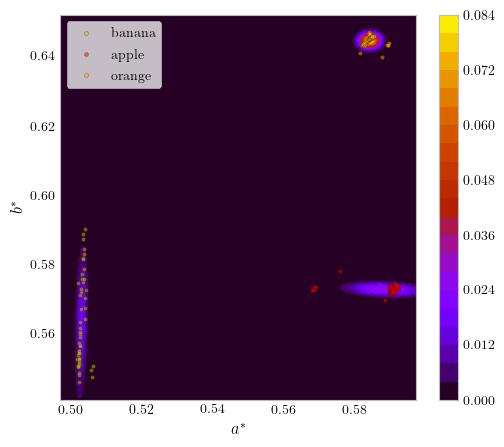

In [297]:
xs = np.linspace(astars.min()-5e-3, astars.max()+5e-3, 500)
ys = np.linspace(bstars.min()-5e-3, bstars.max()+5e-3, 500)
X, Y = np.meshgrid(xs, ys)
zs = np.vstack([X.ravel(), Y.ravel()]).T
Z = np.zeros(len(zs))
for p, m, s in zip(em.P, em.theta['mu'], em.theta['cov']):
    Z += p*stats.multivariate_normal(m, s).pdf(zs)
Z = Z.reshape(X.shape)
Z /= Z.size

plt.figure(figsize=(5*1.15, 5))
plt.plot(ban_features.T[0], ban_features.T[1], 'y.', mec='k', mew=0.25, alpha=0.5)
plt.plot(app_features.T[0], app_features.T[1], 'r.', mec='k', mew=0.25, alpha=0.5)
plt.plot(ora_features.T[0], ora_features.T[1], '.', color='orange', mec='k', mew=0.25, alpha=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.contourf(X, Y, Z, cmap='gnuplot', levels=25)
plt.colorbar()

# plt.savefig('em_feature_space.png', dpi=300, bbox_inches='tight')
plt.show()